In [ ]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

from importlib import reload

In [3]:
data_path = Path("./data/m65_full/")
list(data_path.iterdir())

[PosixPath('data/m65_full/df_morphometrics.pbz2'),
 PosixPath('data/m65_full/cell_type_fine_with_skeleton_no_dense'),
 PosixPath('data/m65_full/df_cell_type_fine.pbz2')]

In [4]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [6]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Choosing the Model

In [ ]:
model_name = "GAT"
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"
dense_adj = getattr(model_class,"dense_adj",False)
directed = getattr(model_class,"directed",False)
print(f"dense_adj= {dense_adj}, directed = {directed}")

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

with_skeleton = True

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None


device = cpu


# Step 1: Loading the Graph Data

In [9]:
data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

segment_id  split_index  nucleus_id external_layer  \
0      864691134277239760            0       89719        LAYER_6   
1      864691134339067925            0      624899        LAYER_6   
2      864691134366116139            0      476756   WHITE_MATTER   
3      864691134378215335            0        3799      LAYER_2/3   
4      864691134527727930            0      631380   WHITE_MATTER   
...                   ...          ...         ...            ...   
60448  864691137197334593            0      376218        LAYER_6   
60449  864691137197344065            0      191436      LAYER_2/3   
60450  864691137197345345            0      584463      LAYER_2/3   
60451  864691137197353281            0      591241        LAYER_5   
60452  864691137197364801            0      488097      LAYER_2/3   

      external_visual_area                                     cell_type_fine  \
0                       V1  [{'nodelist': ['L0_0'], 'features': ['mesh_vol...   
1                       AL  [{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...   
2                       RL  [{'nodelist': ['L0_6'], 'features': ['mesh_vol...   
3                       V1  [{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...   
4                       RL  [{'nodelist': ['L0_0'], 'features': ['mesh_vol...   
...                    ...                                                ...   
60448                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...   
60449                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...   
60450                   RL  [{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...   
60451                   RL  [{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...   
60452                   RL  [{'nodelist': ['L0_9', 'L0_8', 'L0_10', 'L0_6'...   

      cell_type_fine_label  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
60448                  NaN  
60449                  NaN  
60450                  NaN  
60451                  NaN  
60452                  NaN  

[60453 rows x 7 columns]

In [10]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [11]:
data_df.query("cell_type_fine_label == cell_type_fine_label")

segment_id  split_index  nucleus_id external_layer  \
115    864691134884748026            0      366181        LAYER_5   
147    864691134884761338            0      458241        LAYER_4   
170    864691134884769786            0      592718        LAYER_5   
205    864691134884879610            0      304873        LAYER_5   
213    864691134884945146            0       63499      LAYER_2/3   
...                   ...          ...         ...            ...   
60416  864691137197239105            0      262000        LAYER_4   
60417  864691137197241665            0      308938        LAYER_6   
60433  864691137197306177            0      304611        LAYER_5   
60442  864691137197321281            0      434601        LAYER_5   
60445  864691137197329985            0      260468        LAYER_4   

      external_visual_area                                     cell_type_fine  \
115                     V1  [{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...   
147                     RL  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
170                     RL  [{'nodelist': ['L0_18', 'L0_11', 'L0_17', 'L0_...   
205                     V1  [{'nodelist': ['L2_4', 'L1_1', 'L0_3', 'L1_6',...   
213                     V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
...                    ...                                                ...   
60416                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
60417                   V1  [{'nodelist': ['L1_4', 'L0_18', 'L4_1', 'L0_16...   
60433                   V1  [{'nodelist': ['L0_1', 'L0_3', 'L0_6', 'L0_0',...   
60442                   RL  [{'nodelist': ['L0_3', 'L3_3', 'L2_2', 'L2_3',...   
60445                   V1  [{'nodelist': ['L0_3', 'L1_79', 'L1_82', 'L0_1...   

      cell_type_fine_label  
115                     4P  
147                    23P  
170                  5P_IT  
205               IT_short  
213                    23P  
...                    ...  
60416                   4P  
60417               Unsure  
60433                5P_NP  
60442                   6P  
60445                  BPC  

[3338 rows x 7 columns]

In [12]:
data_dict = data_df[["cell_type_fine"]].iloc[1].to_list()[0][0]
data_dict

{'nodelist': array(['L0_1', 'L0_0', 'L0_2'], dtype=object),
 'features': array(['mesh_volume', 'n_spines', 'n_synapses_head', 'n_synapses_neck',
        'n_synapses_post', 'n_synapses_pre', 'skeletal_length',
        'total_spine_volume', 'width_upstream', 'width_downstream',
        'apical_label', 'basal_label', 'skeleton_vector_downstream_phi',
        'skeleton_vector_downstream_theta', 'skeleton_vector_upstream_phi',
        'skeleton_vector_upstream_theta', 'width_no_spine'], dtype=object),
 'adjacency': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]]),
 'feature_matrix': array([[ 3.71170715e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.43345470e+03,  0.00000000e+00,  5.91837642e+01,
          5.91837642e+01,  0.00000000e+00,  1.00000000e+00,
         -6.22637047e-01,  2.00297982e+00, -6.22637047e-01,
          2.00297982e+00,  5.91837642e+01],
        [ 2.99289539e+01,  0.00000000e+00,  0.00000000e+00,
    

# Step 2: Creating the Pytorch Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [13]:
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

# --- b) Creating the Dataset Class --

In [14]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [15]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [16]:
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True,
    features_to_delete=None,
    features_to_keep = None
    ): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds
    
    # --- keeping or not keeping sertain features
    gnn_features = gnn_info["features"]

    keep_idx = np.arange(len(gnn_features))
    if features_to_delete is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k not in features_to_delete])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER DELETE= {keep_idx}")
    if features_to_keep is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k in features_to_keep])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER KEEP = {keep_idx}")

    x = x[:,keep_idx]

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)
    
    if len(y) > 1:
        raise Exception(f"y = {y}")
        
    if y.shape[0] != 1 or y.shape[1] != 1:
        raise Exception(f"y = {y}")


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data

In [17]:
class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        
        
        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y,
                features_to_delete=features_to_delete,
                features_to_keep = features_to_keep,
                verbose = False))

        if self.pre_filter is not None:
            data_list_final = []
            for data in data_list:
                try:
                    if self.pre_filter(data):
                        data_list_final.append(data)
                except:
                    continue
                    
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}")

        if self.pre_transform is not None:
            data_list_final = []
            for j,data in enumerate(data_list):
                try:
                    curr_t = self.pre_transform(data)
                    if curr_t.y.shape[0] != 1 or curr_t.y.shape[1] != 1:
                        raise Exception(f"{j}, data = {curr_t}")
                    data_list_final.append(curr_t)
                except:
                    continue
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}, data = {d}")

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [18]:
if with_skeleton:
    gnn_task_name = f"{gnn_task}_with_skeleton"
else:
    gnn_task_name = f"{gnn_task}"

if dense_adj:
    processed_data_folder = data_path / Path(f"{gnn_task_name}")#_processed_dense")
elif directed:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_directed")#_processed_dense")
else:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_no_dense")#_processed_dense")
    
# try:
#     su.rm_dir(processed_data_folder)
# except:
#     pass

processed_data_folder.mkdir(exist_ok = True)

In [19]:
max_nodes = np.max(all_batch_df_norm.index.to_numpy()) + 1

class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes
    
if dense_adj:
    #gets the maximum number of nodes in any of the graphs
    transform_list = [
        transforms.ToUndirected(),
        T.ToDense(max_nodes),
        #transforms.NormalizeFeatures(),
    ]
    pre_filter = MyFilter()
elif directed:
    transform_list = []
    pre_filter = None
else:
    transform_list = [
        transforms.ToUndirected(),
    ]
    
    pre_filter = None
    

transform_norm = transforms.Compose(transform_list)
dataset = CellTypeDataset(
        processed_data_folder.absolute(),
        pre_transform = transform_norm,
        pre_filter = pre_filter,
        )

In [20]:
# for j,d in enumerate(dataset):
#     if d.y.shape[0] != 1 or d.y.shape[1] != 1:
#         raise Exception(f"{j}")

In [21]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [22]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(58948):
Number of graphs: 58948
Number of features: 14
Number of classes: 32

Data(x=[3, 14], edge_index=[2, 4], y=[1, 1])
Number of nodes: 3
Number of edges: 4
Average node degree: 1.33


# --- c) Splitting the Data into Labeled and unlabeled

In [23]:
labeled_mask = np.array(
    [True if k.y[0][0] > 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

3338

In [24]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [25]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [26]:
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

test size = 667.0 (0.2 %)
validation size = 667.0 (0.2 %)
train_size = 2004.0
data_lengths_with_train = [2004  667  667]
Number of training graphs: 2004
Number of test graphs: 667
Number of val graphs: 667


In [27]:
# # if wanted to try and add weights
# y_train = np.array([int(data.y[0][0].numpy()) for data in train_dataset])
# y_train_classes,y_train_count = np.unique(y_train,return_counts = True)
# y_train_classes,y_train_count

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# weight = {i:1/}
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [28]:
if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = False)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

# Step 3a; Picking the Model

In [61]:
n_epochs = 100


import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = 32, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    global_pool_type="mean",
    n_layers = 2,
    first_heads = 4,
    output_heads = 2,
    classifier_flat = True
    
)

optimizer_kwargs_global = dict(
    lr=0.01
)

all_run_kwargs = [
    #dict(architecture_kwargs = dict(n_hidden_channels = 64),),
    
#     dict(architecture_kwargs = dict(n_hidden_channels = 8)),
#     dict(),
#     dict(architecture_kwargs = dict(n_hidden_channels = 128)),
    
    dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 8)),
    dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 32),),
    #dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 64),),
    dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 128),),
    
    
    
#     dict(architecture_kwargs = dict(n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 8,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 8,global_pool_type="add"),),

]

# Step 3: Training the Model

In [62]:
import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [63]:
for j,config_dict in enumerate(all_run_kwargs):
    
    architecture_kwargs = config_dict.get("architecture_kwargs",dict())
    optimizer_kwargs = config_dict.get("optimizer_kwargs",dict())
    
    architecture_kwargs = gu.merge_dicts([architecture_kwargs_global.copy(),architecture_kwargs])
    optimizer_kwargs = gu.merge_dicts([optimizer_kwargs_global.copy(),optimizer_kwargs])
    
    run_kwargs = gu.merge_dicts([architecture_kwargs,optimizer_kwargs])

    
    if verbose:
        print(f"\n\n\n****------ Running Model Config {j} with following parameters ------****\n{run_kwargs}")

    model = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
    print(model)


    
    # ---------------- Configuring the Tensorboard and Checkpoinns--------------------
    from torch.utils.tensorboard import SummaryWriter

    tensorboard_dir = Path("./tensorboard")
    tensorboard_dir.mkdir(exist_ok=True)
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
    tensorboard_dir.mkdir(exist_ok=True)

    tensorboard_file_name = (f'{model_name}_' 
                             + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
    tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
    print(f"tensorboard_file_name = {tensorboard_file_name}")
    tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
    try:
        su.rm_dir(tensorboard_file)
    except:
        pass
    tensorboard_file.mkdir(exist_ok = True)


    #-- when to save a checkpoint of the model
    checkpoint_dir = Path("./model_checkpoints")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

    try:
        su.rm_dir(checkpoint_path)
    except:
        pass

    checkpoint_path.mkdir(exist_ok = True)
    n_epoch_for_checkpoint = 5

    writer = SummaryWriter(tensorboard_file)
    

    print(model)


    # weights = weight#[0.1,0.5,,1,0.7,1,1,1]
    # class_weights = None
    class_weights = torch.FloatTensor(weights).to(device)

    tensor_map = None

    def train():
        model.train()

        for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
            #print(f"data = {data}")
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)
            y_true = data.y.squeeze_()
            #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
            loss = F.nll_loss(
                torch.log(out), y_true,
                weight = class_weights,
            )  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            return loss


    def test(loader,verbose = False):
        model.eval()
        y_pred_list = []
        y_true_list = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)

            y_pred = out.argmax(dim=1)  # Use the class with highest probability.
            y_true = data.y.squeeze_()
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
    #         error_idx = np.where(pred > 0)[0]
    #         if len(error_idx) > 0:
    #             print(f"error_idx = {error_idx}")
        y_pred = torch.cat(y_pred_list)
        y_true = torch.cat(y_true_list)

        return evu.metric_dict(
            y_true,
            y_pred,
            tensor_map=tensor_map,
            metrics=["accuracy"],
        )

    log_to_tensorboard = True
    for epoch in range(0, n_epochs):
        loss = train()
        writer.add_scalar('loss',loss,epoch) # new line
        train_metric_dict = test(train_loader)#train_loader)
        val_metric_dict = test(val_loader)#test_loader)

        if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
            val_acc = val_metric_dict['accuracy'].numpy()
            checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
            print(f"Saving off checkpoint {checkpoitn_filepath}")
            mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


        print(f'Epoch: {epoch:03d}, loss = {loss}')
        for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
            print_log = f"   {type_name} metrics: "
            for k,v in metric_dict.items():
                if log_to_tensorboard:
                    writer.add_scalar(f'{type_name}_{k}',v,epoch)
                print_log += f" {k}: {v:4f},"

            print(print_log)
        
        if val_metric_dict["accuracy"] < 0.0001:
            break




****------ Running Model Config 0 with following parameters ------****
{'n_hidden_channels': 8, 'global_pool_type': 'mean', 'n_layers': 1, 'first_heads': 4, 'output_heads': 2, 'classifier_flat': True, 'lr': 0.01}
GAT(
  (conv0): GATConv(14, 8, heads=4)
  (classifier): ClassifierFlat(
    (lin): Linear(in_features=32, out_features=32, bias=True)
  )
)
tensorboard_file_name = GAT_n_hidden_channels_8_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_classifier_flat_True_lr_0.01_with_skeleton_True
GAT(
  (conv0): GATConv(14, 8, heads=4)
  (classifier): ClassifierFlat(
    (lin): Linear(in_features=32, out_features=32, bias=True)
  )
)
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  5  6  7  8 10 11 13 14 16 18 19 20 23 26 28 29],y_pred_counts = [324  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  5  6  8  9 18],y_pred_counts = [  93 1148  235    7    6  400    3  112]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  5  6  8  9 18],y_pred_counts = [ 34 376  70   1   1 136   4  45]
Epoch: 009, loss = 2.6021251678466797
   train metrics:  accuracy: 0.302395,
   val metrics:  accuracy: 0.310345,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 18],y_pred_counts = [  1 337 333 340  23  10 858  43  59]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 14 18],y_pred_counts = [  1 105  99 114   5   2 297  14   1  29]
Epoch: 019, loss = 2.1289799213409424
   train metrics:  accuracy: 0.256487,
   val metrics:  accuracy: 0.223388,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 12 14 18],y_pred_counts = [  3 170  86  63  24  25 192  58   5  12  29]
Epoch: 028, loss = 1.872178077697754
   train metrics:  accuracy: 0.320359,
   val metrics:  accuracy: 0.310345,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  6 565 297 186  80  48 505 192   3  24  49  49]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 41 558 539 101  54  22 413  78  18  62 100  18]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 18 196 168  24  19   8 140  19   7  25  32  11]
Epoch: 038, loss = 1.6540696620941162
   train metrics:  accuracy: 0.383733,
   val metrics:  accuracy: 0.361319,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 32 670 411  75  43  33 474  52  33  69  92  20]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 12 220 133  12  10  20 165  15  13  28  28  11]
Epoch: 048, loss = 1.445656418800354
   train metrics:  accuracy: 0.387725,
   val metrics:  accuracy: 0.391304,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 43 417 563 221  46  24 409  60  35  58  97  31]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 15 144 170  62  10  15 151  17  16  23  29  15]
Epoch: 058, loss = 1.5835152864456177
   train metrics:  accuracy: 0.401198,
   val metrics:  accuracy: 0.370315,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 15 198 128  36   9  27 147   8  32  26  29  12]
Epoch: 067, loss = 1.2523536682128906
   train metrics:  accuracy: 0.412176,
   val metrics:  accuracy: 0.419790,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 45 600 432 113  41  56 409  36  88  67  96  21]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 17 206 132  23   9  27 147   9  30  27  29  11]
Epoch: 068, loss = 1.4715893268585205
   train m

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 72 507 587 109  49  25 374  42  55  69  94  21]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 28 177 176  28  14  14 136  11  18  27  27  11]
Epoch: 077, loss = 1.1250110864639282
   train metrics:  accuracy: 0.420659,
   val metrics:  accuracy: 0.410795,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 53 560 381 277  51  34 349  80  29  69  99  22]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 21 189 112  79  17  18 127  21  12  26  31  14]
Epoch: 087, loss = 1.4449280500411987
   train metrics:  accuracy: 0.418164,
   val metrics:  accuracy: 0.422789,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 47 706 417  81  50  48 354  41  69  57 100  34]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 18 242 124  16  14  25 122   9  26  22  30  19]
Epoch: 097, loss = 1.4385149478912354
   train metrics:  accuracy: 0.436128,
   val metrics:  accuracy: 0.460270,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  2 359 638 410  79   1 236  99   1  14  56 109]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 12 14 18],y_pred_counts = [  1 125 203 126  25   2  89  30   3  18  45]
Epoch: 006, loss = 2.3551011085510254
   train metrics:  accuracy: 0.375250,
   val metrics:  accuracy: 0.331334,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 33 288 672 159  54  37 425 116  60  57  47  56]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 11  93 214  51  13  17 155  34  15  22  17  25]
Epoch: 016, loss = 1.5322462320327759
   train metrics:  accuracy: 0.394212,
   val metrics:  accuracy: 0.356822,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 22 402 601 314  55  61 271  63  11  84  96  24]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  9 131 195  95  15  28  98  13   7  34  34   8]
Epoch: 026, loss = 1.460387945175171
   train metrics:  accuracy: 0.432136,
   val metrics:  accuracy: 0.407796,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 36 840 220 223  50  37 301  62  37  57 118  23]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 14 282  68  57  15  20 110  16  13  21  41  10]
Epoch: 036, loss = 1.2863541841506958
   train metrics:  accuracy: 0.417166,
   val metrics:  accuracy: 0.434783,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 31 341 877 110  77  60 266  13  38  60 106  25]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 16 117 276  30  24  24  93   6  13  22  32  14]
Epoch: 046, loss = 0.901121973991394
   train metrics:  accuracy: 0.436128,
   val metrics:  accuracy: 0.415292,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 22 319 784  71  74  68 232 138 105  61 103  27]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 10 109 252  17  23  32  83  38  35  23  33  12]
Epoch: 056, loss = 0.9686017036437988
   train metrics:  accuracy: 0.441118,
   val metrics:  accuracy: 0.406297,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 33 862 245 200  61  72 273  44  27  59  94  34]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 14 293  72  51  22  35  94  10  10  23  29  14]
Epoch: 066, loss = 1.3412790298461914
   train metrics:  accuracy: 0.443613,
   val metrics:  accuracy: 0.434783,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 22 476 593 121  79  64 282 129  48  68 101  21]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 12 172 185  26  24  27  99  36  20  24  30  12]
Epoch: 076, loss = 1.1627975702285767
   train metrics:  accuracy: 0.458583,
   val metrics:  accuracy: 0.439280,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 29 580 472 191  67  73 306  47  52  56 103  28]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 16 210 140  47  24  35 101  13  16  17  35  13]
Epoch: 086, loss = 0.9778168797492981
   train metrics:  accuracy: 0.461577,
   val metrics:  accuracy: 0.443778,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 54 599 627  75  44  53 225  53  83  45 103  43]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 26 203 202  18   8  23  81  12  26  15  36  17]
Epoch: 096, loss = 0.9941326975822449
   train metrics:  accuracy: 0.455589,
   val metrics:  accuracy: 0.433283,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 14 18],y_pred_counts = [344  29  28  11   1 197  16   8  33]
Saving off checkpoint model_checkpoints/GAT/GAT_n_hidden_channels_128_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_classifier_flat_True_lr_0.01_with_skeleton_True_checkpoints/GAT_n_hidden_channels_128_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_classifier_flat_True_lr_0.01_with_skeleton_True_epoch_5
Epoch: 005, loss = 1.6310011148452759
   train metrics:  accuracy: 0.340319,
   val metrics:  accuracy: 0.349325,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  7 420 727 212  57  50 268  55   3  77 102  26]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  3 153 219  61  14  24 102  14   1  25  35  16]
Saving off checkpoint model_checkpoints/GAT/GAT_n_hidden_channels_128_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_classifier_flat_True_lr_0.01_with_skeleton_True_checkpoints/GAT_n_hidden_channels_128_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_clas

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 34 102 231  99  22   8  72  30   3  17  28  21]
Epoch: 024, loss = 1.2132142782211304
   train metrics:  accuracy: 0.429641,
   val metrics:  accuracy: 0.383808,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 52 408 643 236  74  34 235 135   5  49  91  42]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 58 387 719 124  65  18 349  22  78  63  89  32]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 17 130 242  38  19  10 115   6  24  21  28  17]
Epoch: 034, loss = 1.0287140607833862
   train metrics:  accuracy: 0.447605,
   val metrics:  accuracy: 0.421289,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  5 107 260  54  14  23  95  30  13  15  35  16]
Epoch: 043, loss = 1.2496079206466675
   train metrics:  accuracy: 0.448603,
   val metrics:  accuracy: 0.401799,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 13 461 639 237  50  50 262  82  25  41 112  32]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 17 331 716 142  65  65 335  99  48  60  96  30]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 11 114 246  33  18  29 109  21  19  21  31  15]
Epoch: 053, loss = 1.0614838600158691
   train metrics:  accuracy: 0.440120,
   val metrics:  accuracy: 0.404798,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 13 144 262  11  31  18  88  12  21  21  27  19]
Epoch: 062, loss = 1.0577869415283203
   train metrics:  accuracy: 0.429641,
   val metrics:  accuracy: 0.412294,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 31 474 737  60  78  44 278  69  46  65  89  33]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   

# Step 4: Picking the best model

In [85]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard/GAT --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# import tensorboard_utils as tbu
# df_board = df_tensorboard("./tensorboard/",verbose = True)
# df_board.query("(run=='DiffPooln_hidden_channels_32') and (name=='train_accuracy')")

In [38]:
list(checkpoint_dir.iterdir())

[PosixPath('model_checkpoints/GAT/GAT_n_hidden_channels_8_global_pool_type_mean_n_layers_2_first_heads_8_output_heads_1_classifier_flat_True_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/GAT/GAT_n_hidden_channels_128_global_pool_type_mean_n_layers_2_first_heads_8_output_heads_1_classifier_flat_True_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/GAT/GAT_n_hidden_channels_32_global_pool_type_mean_n_layers_2_first_heads_8_output_heads_1_classifier_flat_True_lr_0.01_with_skeleton_True_checkpoints')]

In [86]:
winning_name = "GAT_n_hidden_channels_32_global_pool_type_mean_n_layers_1_first_heads_4_output_heads_2_classifier_flat_True_lr_0.01_with_skeleton_True"
epoch = 95
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
winning_filepath.exists()

True

In [87]:
# GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_95 #good one for seperation

# Step 5: Running Embedding for all cell types (Can Run in Batches)

In [90]:
architecture_kwargs_curr = dict(n_hidden_channels = 32,global_pool_type = "mean",n_layers = 1,first_heads=4,output_heads=2,classifier_flat = True)
architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
architecture_kwargs

{'n_hidden_channels': 32,
 'global_pool_type': 'mean',
 'n_layers': 1,
 'first_heads': 4,
 'output_heads': 2,
 'classifier_flat': True}

In [91]:
model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    #use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

GAT(
  (conv0): GATConv(14, 32, heads=4)
  (classifier): ClassifierFlat(
    (lin): Linear(in_features=128, out_features=32, bias=True)
  )
)

In [92]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [93]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/922 [00:00<?, ?it/s]

In [47]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unknown', 'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier',
        'l1vip', 'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([   13,   984,   737,   365,    72,   142,    22,   254,   105,
          198,    19,    71,    61,    14,    29,    33,    32,    75,
           11,     5,    36, 55610,    20,     7,    13,     2,     1,
            2,     7,     6,     1,     1]))

In [48]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([False, False, False, ..., False, False, False])

# Step 6: Plotting Embeddings

In [94]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [95]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [96]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

# Prep) PCA Preprocessing

<Figure size 432x288 with 0 Axes>

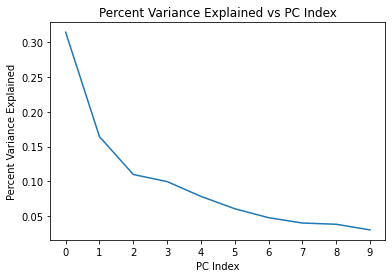

In [97]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [98]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

In [99]:
X_input=X[y!= "Unknown"]
y_input = y[y != "Unknown"]

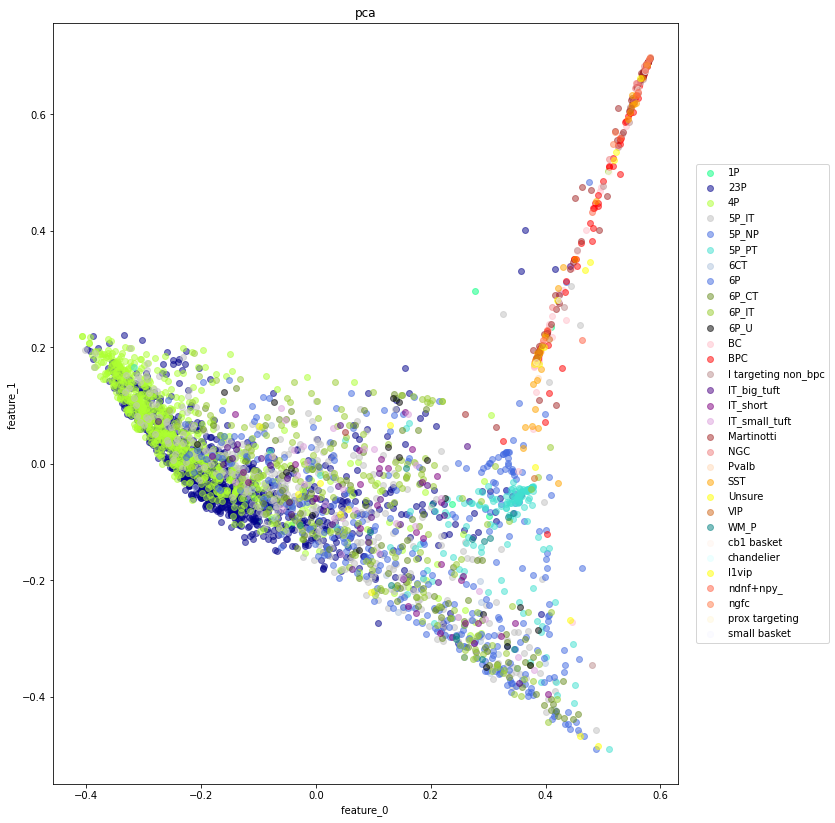

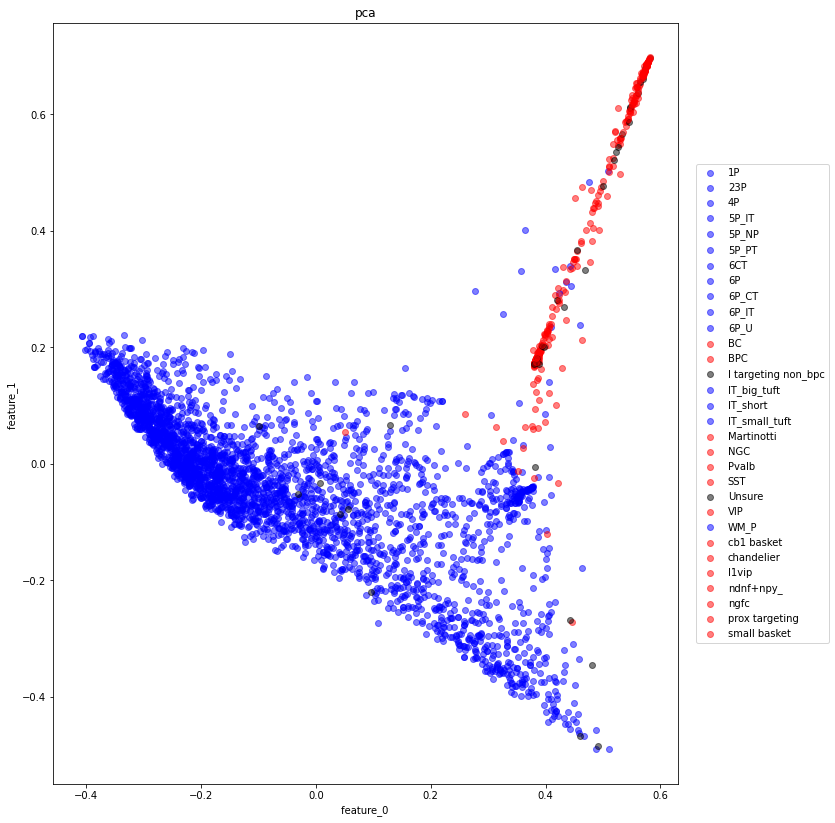

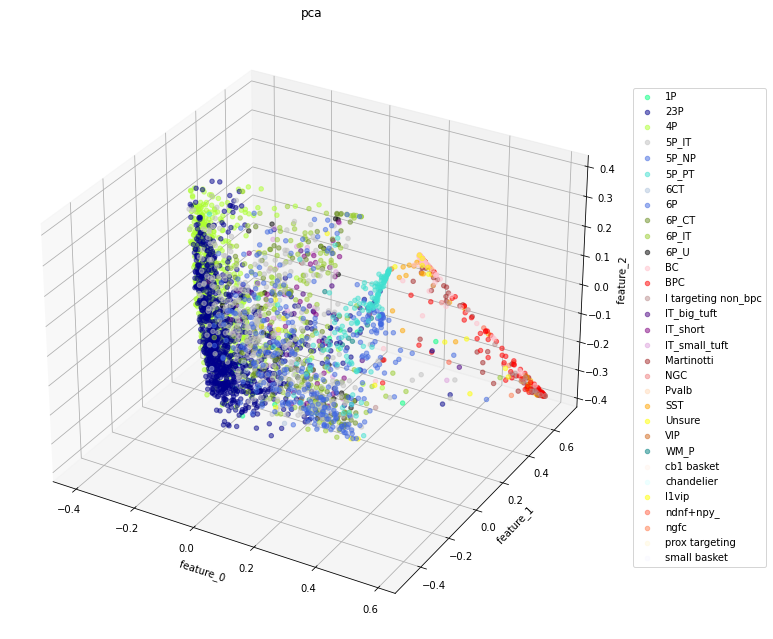

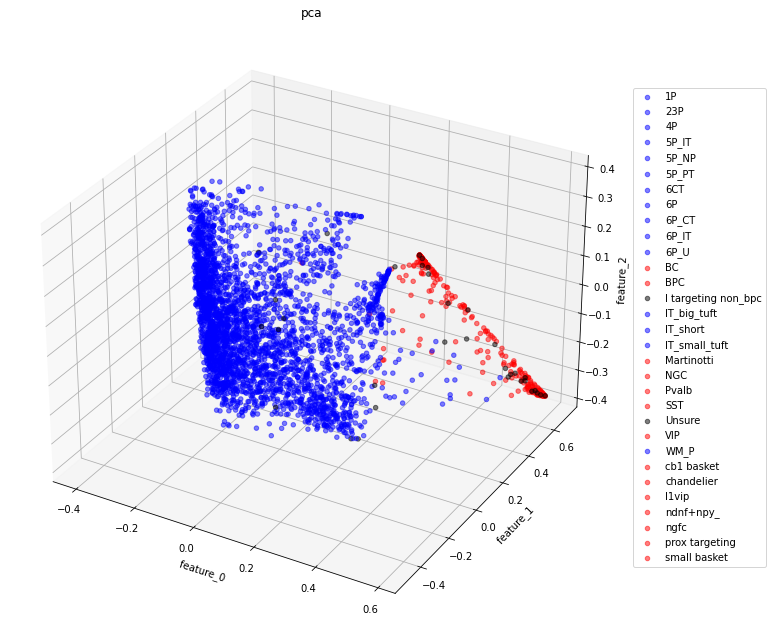

In [100]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

# b) UMAP (0.5)

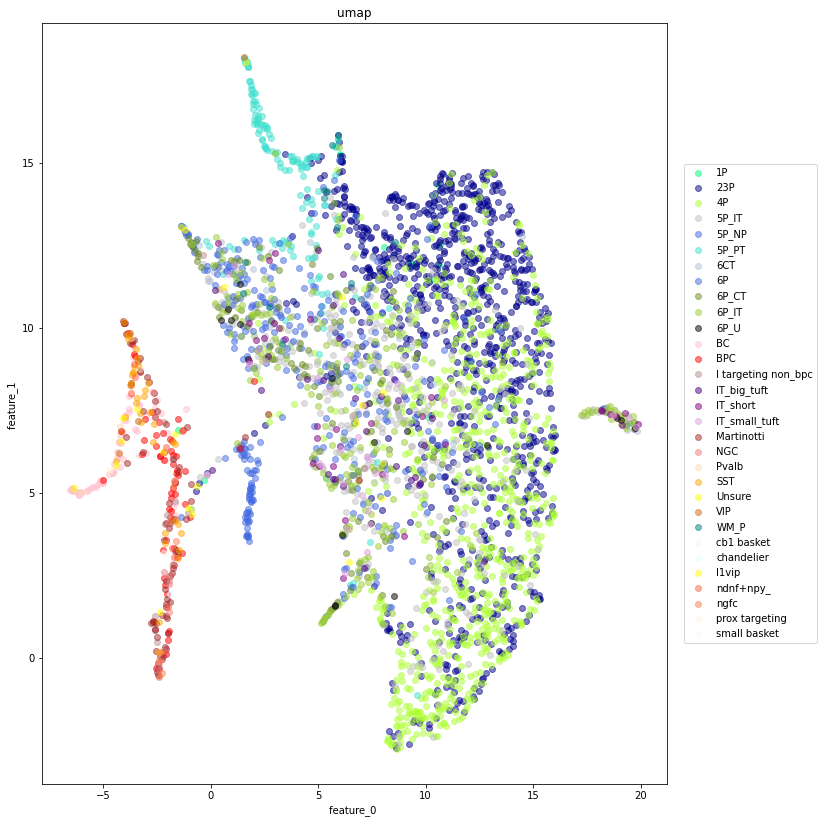

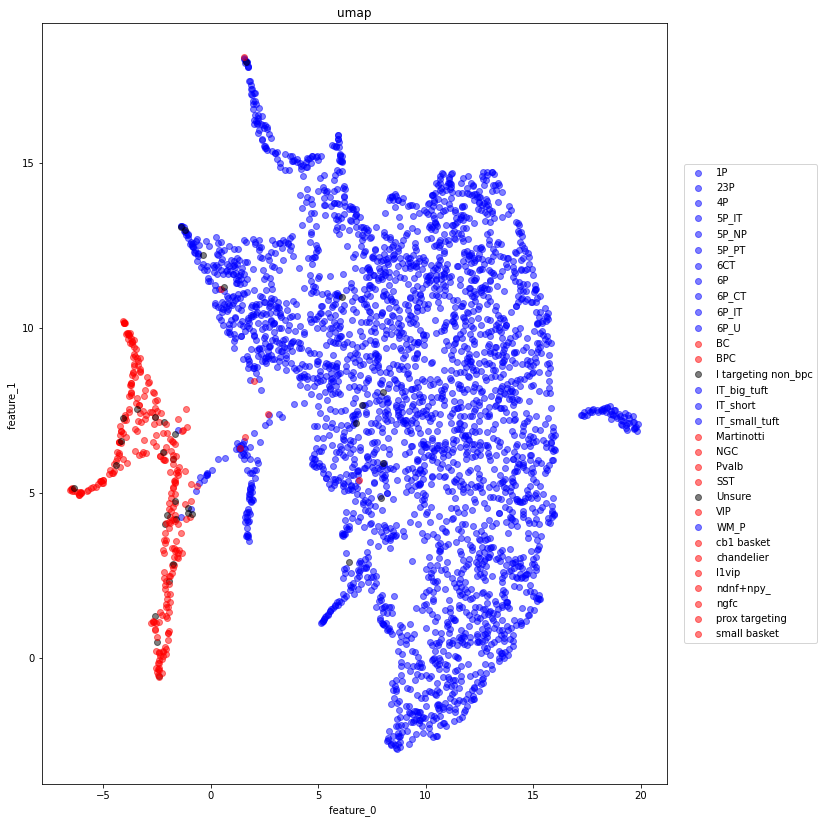

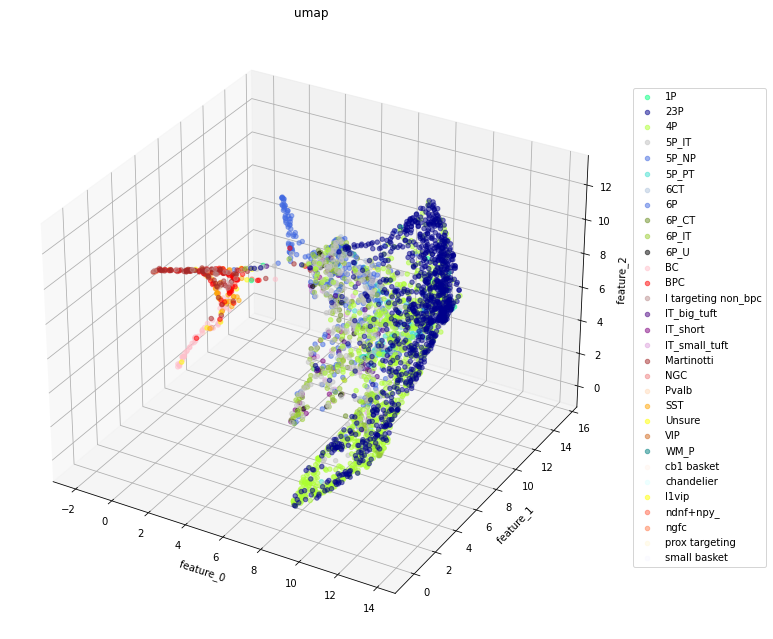

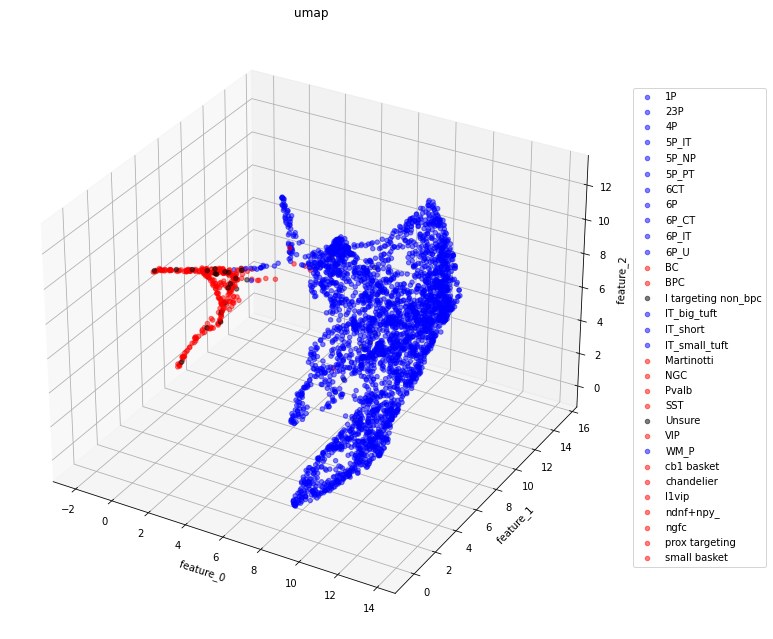

In [101]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
)

# b) UMAP (0.2)

In [102]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

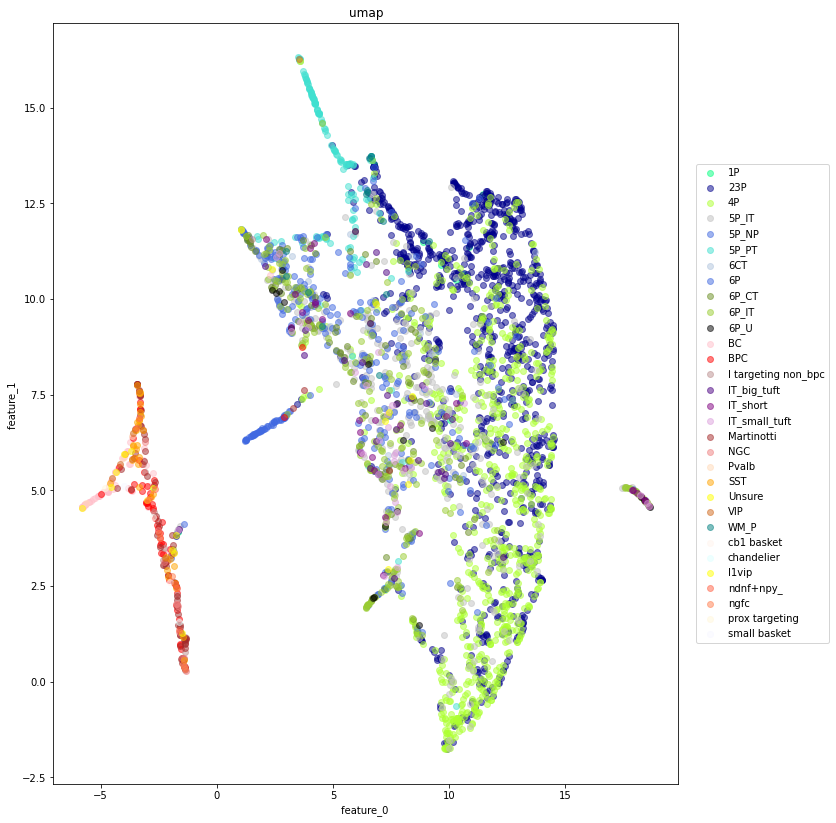

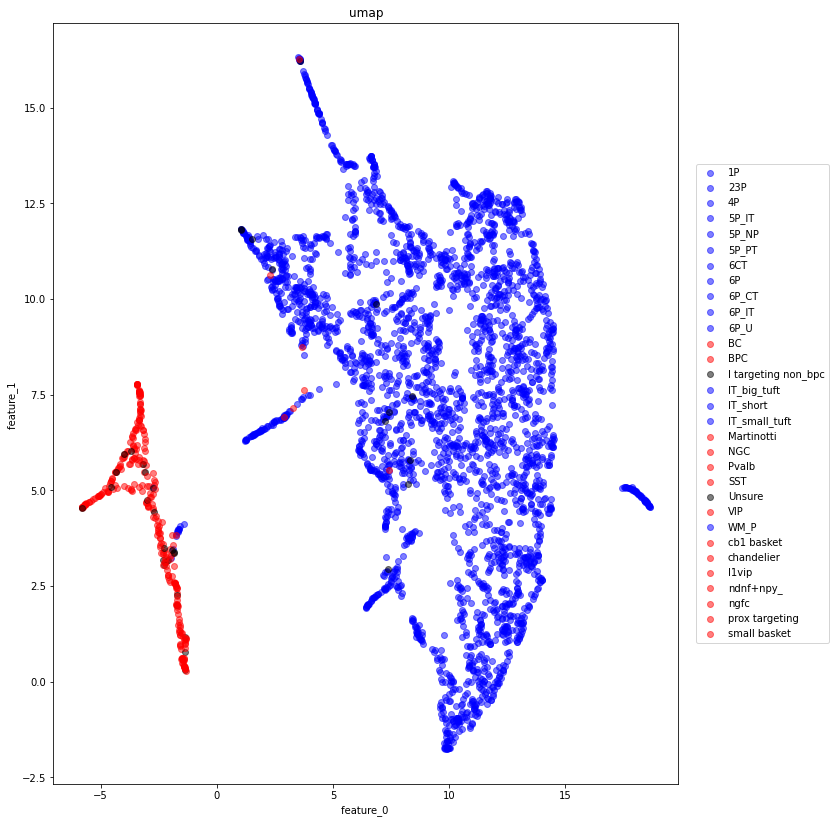

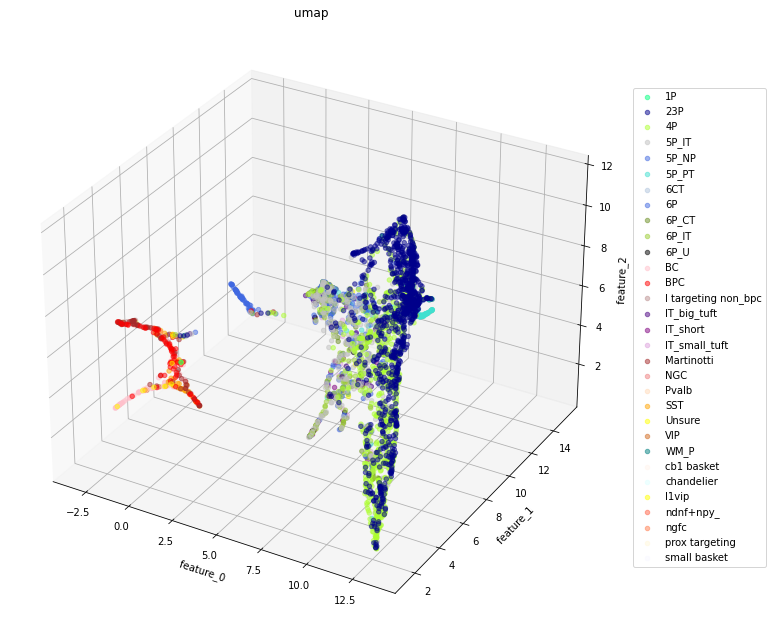

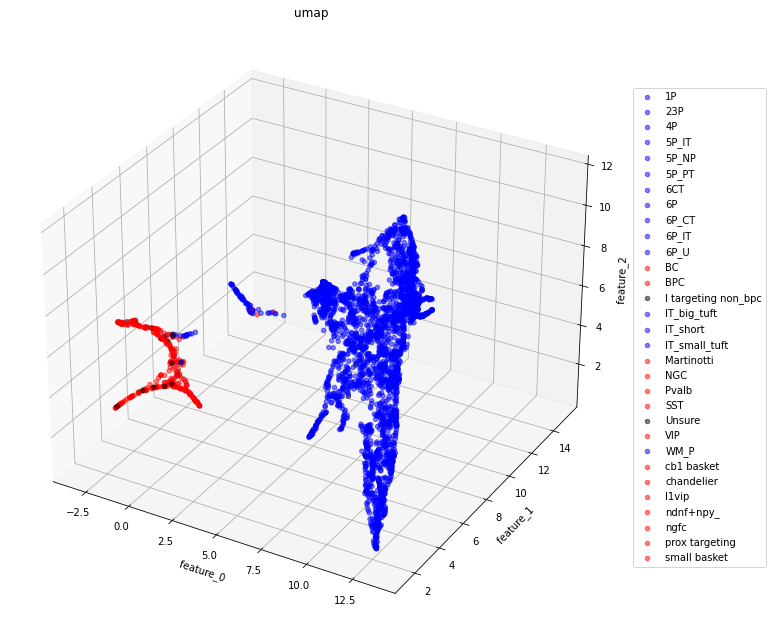

In [103]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

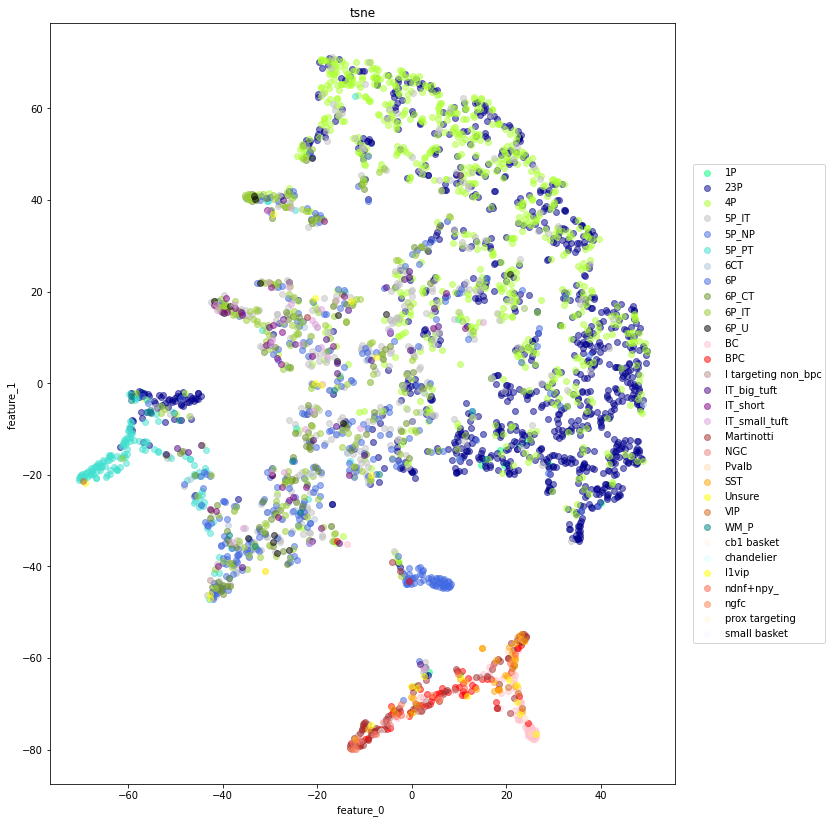

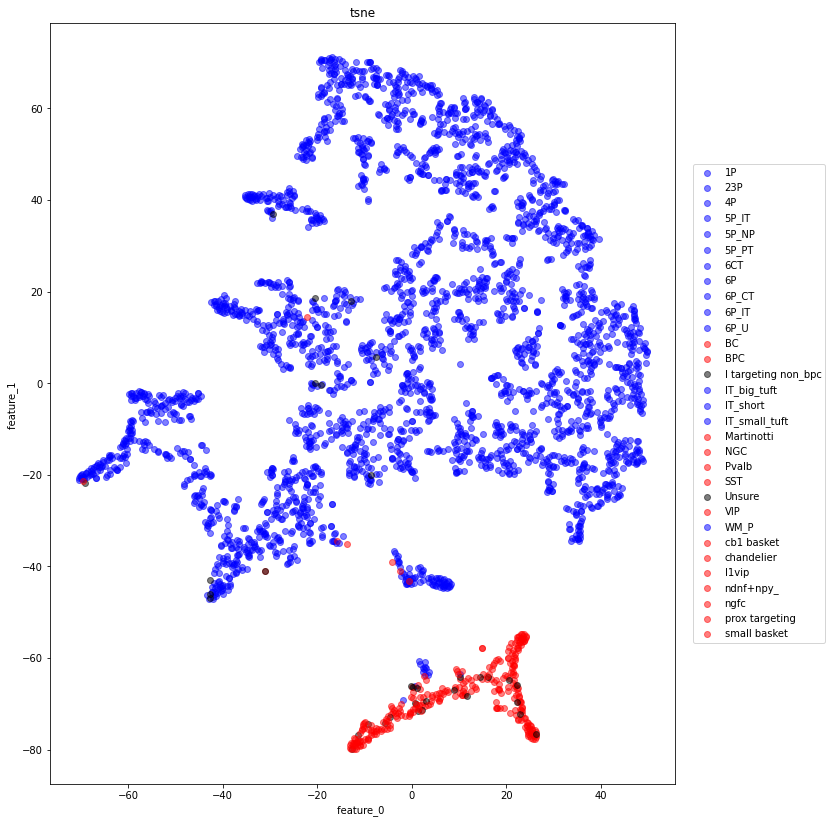

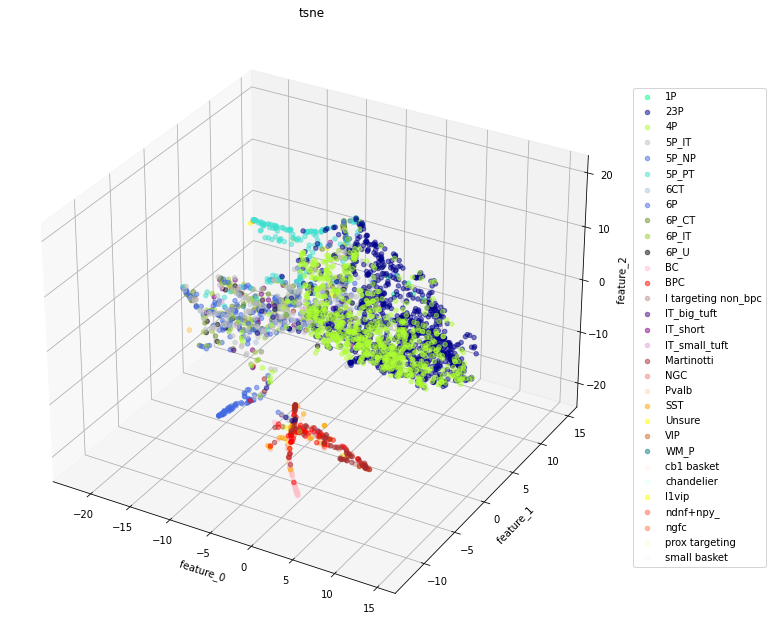

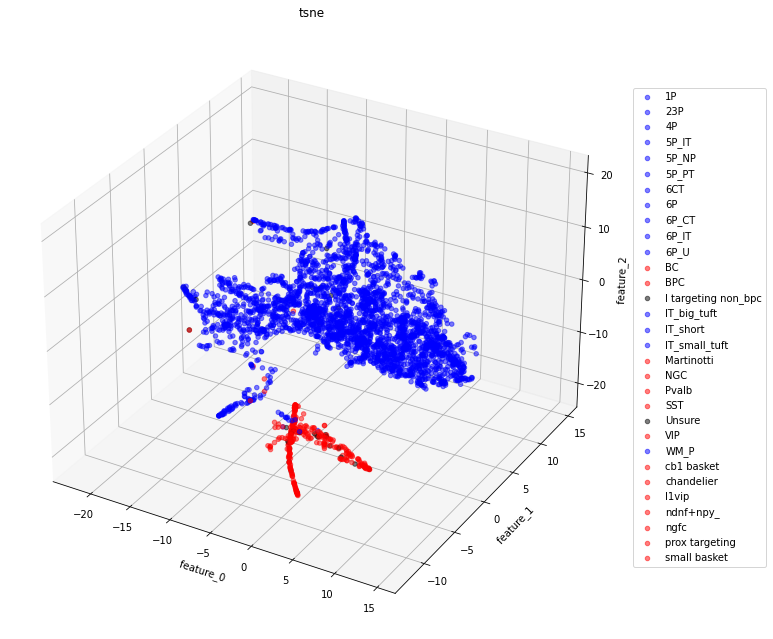

In [104]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
)

# Computing the Test Accuracy

In [105]:
all_data_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.4496240601503759
e_i_label test accuracy: 0.9578947368421052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [106]:
all_data_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPoolGCN":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.4343891402714932
e_i_label test accuracy: 0.9411764705882353


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
